In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns

from modules import *
input_data = InputData("ANSPRACHE_MARKETING_IMPUTED", max_twin_num = 10, kernel_size = 1) #Options: ANSPRACHE, ANSPRACHE_MARKETING_IMPUTED

There are 7 NaN values in the data which are replaced with 0s.
There are 9 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 8 NaN values in the data which are replaced with 0s.
There are 16 NaN values in the data which are replaced with 0s.
There are 14 NaN values in the data which are replaced with 0s.
There are 8 NaN values in the data which are replaced with 0s.
There are 9 NaN values in the data which are replaced with 0s.
There are 9 NaN values in the data which are replaced with 0s.
There are 3 NaN values in the data which are replaced with 0s.
There are 28 NaN values in the data which are replaced with 0s.
There are 25 NaN values in the data which are replaced with 0s.
There are 49 NaN values in the data which are replaced with 0s.
There are 9 NaN values in the data which are repla

In [2]:
# TODO: evaluieren der korrekten window positionen unter zero indexing, was sind die mindest dinger für die grid search windows, input dataen vollenden (z.B. NAs), die iid bootstraps implementieren
# alternativ den Mean Absolute Scaled Error und Symmetric Mean Absolute Percentage Error testen
#MASE: normieren des Fehlers mit mit mae eines naiven benchmarks

# FIXME: 

# NOTE: NA printout currently disabled for debugging, must be looked into later, evaluate why identical bounds from paper are not robust to all parameter combinations
#kann ich meine Ergebnisse eindeutiger machen, wenn ich mehr als 100 Testartikel nehme?
# wo würde ich die cv der samples untersuchen?
# Evaluate influence of sample size on calculcation time
# Wie kann ich unterscheiden, ob der Fehler vom Model oder von den Twins kommt

# Window Size Analysis

[  0.   5.  13.  21.  29.  37.  45.  53.  61.  69.  77.  85.  93. 101.
 109. 117. 125. 133. 141. 149. 157. 165. 173. 181. 189. 197. 205. 213.
 221. 229. 237. 245. 253. 261. 269. 277. 285. 293. 301. 303.]
[  2.  10.  18.  26.  34.  42.  50.  58.  66.  74.  82.  90.  98. 106.
 114. 122. 130. 138. 146. 154. 162. 170. 178. 186. 194. 202. 210. 218.
 226. 234. 242. 250. 258. 266. 274. 282. 290. 298. 305. 305.]


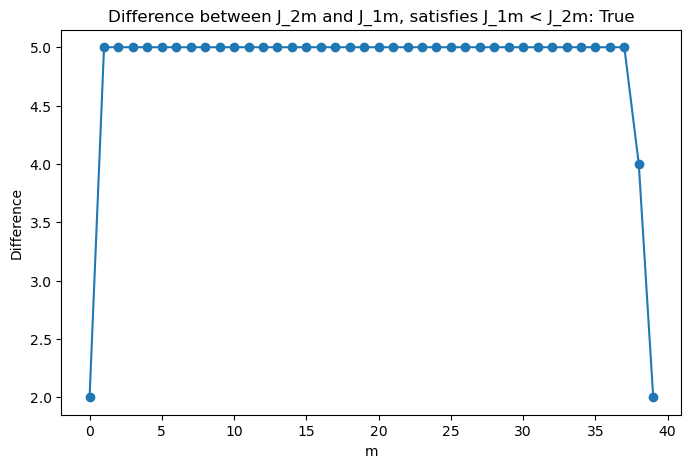

In [3]:
#sind meine windows centered oder asymmetrisch? -> den zenterpunkt +0.5 setzen
#window size dürfen nur gerade zahlen sein, sonst sind grenzen dezimalzahlen
#dadurch, dass der ub nicht inclusive ist, sind die intervalle nicht symmetrisch um den Index m*b
#was wäre eine Lösung? (abwägung zwischen symmetrischem, ungeraden intervall und asymmetrischem, geraden intervall)
#window size 1 hat die beste performance, dass müssen wir also eigentlich berücksichtigen
#-> wie verhalten sich die intervallgrenzen bei window size 1? mit den decimalzahlengrenzen
#-> vielleicht is es deshalb nicht viel besser als der standard bootstrap
N = 313
b = 8
w = 4
M = int(np.ceil(N / b))

# Compute J_1m and J_2m
J_1m_values = np.maximum(0, np.minimum(np.arange(M) * b - w/2-1, N-b - w/2))# Shape: (M,)
print(J_1m_values)
J_2m_values = np.maximum(0, np.minimum(np.arange(M) * b + w/2, N-b))    # Shape: (M,)
print(J_2m_values)

# Compute the difference
difference = J_2m_values - J_1m_values

# Plot the difference
plt.figure(figsize=(8, 5))
plt.plot(range(M), difference, marker='o', linestyle='-', label='J_2m - J_1m')
plt.xlabel('m')
plt.ylabel('Difference')
plt.title(f'Difference between J_2m and J_1m, satisfies J_1m < J_2m: {~np.any(J_1m_values >= J_2m_values)}')
plt.show()

# Empirical Test of Local Block Bootstrap

In [ ]:
#parameter suche nur auf den testdaten
# input_validation = InputData("ANSPRACHE_MARKETING_IMPUTED", max_twin_num = 10, kernel_size = 1)
# input_validation.TwinData = input_validation.TestData

# GridEvaluation.run_grid(input_data, output_file="method_validation")

There are 7 NaN values in the data which are replaced with 0s.
There are 9 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 8 NaN values in the data which are replaced with 0s.
There are 16 NaN values in the data which are replaced with 0s.
There are 14 NaN values in the data which are replaced with 0s.
There are 8 NaN values in the data which are replaced with 0s.
There are 9 NaN values in the data which are replaced with 0s.
There are 9 NaN values in the data which are replaced with 0s.
There are 3 NaN values in the data which are replaced with 0s.
There are 28 NaN values in the data which are replaced with 0s.
There are 25 NaN values in the data which are replaced with 0s.
There are 49 NaN values in the data which are replaced with 0s.
There are 9 NaN values in the data which are repla

Parameter Grid Search:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# df_validation = pd.read_csv("/Users/chris/Projects/Diplom/results/method_validation.csv") #method_validation
# df_validation.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().sort_values("WASSERSTEIN").reset_index()[["WINDOW_SIZE", "BLOCK_SIZE", "MAPE", "RMSE", "BIAS", "WASSERSTEIN"]].head(20) #median, bc distribution is skewed

,WINDOW_SIZE,BLOCK_SIZE,MAPE,RMSE,BIAS,WASSERSTEIN
0,25,1,36.382467,191.591381,3.822927,177.302978
1,5,1,36.379957,190.838670,4.474506,177.344600
2,17,1,36.272229,192.071158,3.918661,177.354998
3,37,1,37.180587,195.130281,4.055738,177.377190
4,13,1,36.584576,191.357078,4.254118,177.444421
5,29,1,36.760510,191.857936,4.082070,177.460909
6,0,1,36.330560,199.072927,3.481401,177.471334
7,41,1,37.282693,193.594285,5.624070,177.640833
8,33,1,37.032632,194.016832,3.547898,177.650707
9,9,1,36.438349,191.382295,4.516532,177.734624


# Parameter Tuning

In [9]:
GridEvaluation.run_grid(input_data) #3min auf dem Mac, dauert deutlich länger, wenn der input die instance ist und nicht die klasse

Parameter Grid Search:   0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
df_grid_results = pd.read_csv("results/grid_results.csv")
df_grid_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().sort_values("BIAS").reset_index()[["WINDOW_SIZE", "BLOCK_SIZE", "MAPE", "RMSE", "BIAS", "WASSERSTEIN"]].head(20) #median, bc distribution is skewed
# auf Shortcomings des MAPE hinweisen in der Arbeit!

,WINDOW_SIZE,BLOCK_SIZE,MAPE,RMSE,BIAS,WASSERSTEIN
0,29,13,39.817248,266.990987,-6.930773,217.943152
1,21,16,40.100232,275.507101,-6.450321,228.759733
2,21,13,39.618182,265.374294,-5.897384,217.641018
3,25,16,40.399164,278.224237,-5.581450,230.834996
4,29,19,40.486126,292.754353,-5.339408,231.423612
5,29,10,39.034203,256.099986,-5.214559,211.248341
6,37,10,39.630192,261.690468,-4.975967,211.433472
7,17,13,39.574194,265.415771,-4.958497,218.980135
8,25,19,40.462120,291.677031,-4.654412,232.062818
9,29,16,40.301664,278.510622,-4.645979,228.826915


# Best Parameter Configuration vs. Benchmark

In [11]:
best_params = (1, 1)

results  = []
for test_item_key in input_data.TestData.keys():
    results.append(GridEvaluation.run_lbb(input_data.TwinData[test_item_key], input_data.TestData[test_item_key], test_item_key, *best_params))
    results.append(GridEvaluation.run_idd(input_data.TwinData[test_item_key], input_data.TestData[test_item_key], test_item_key))

df_results = pd.DataFrame(results)

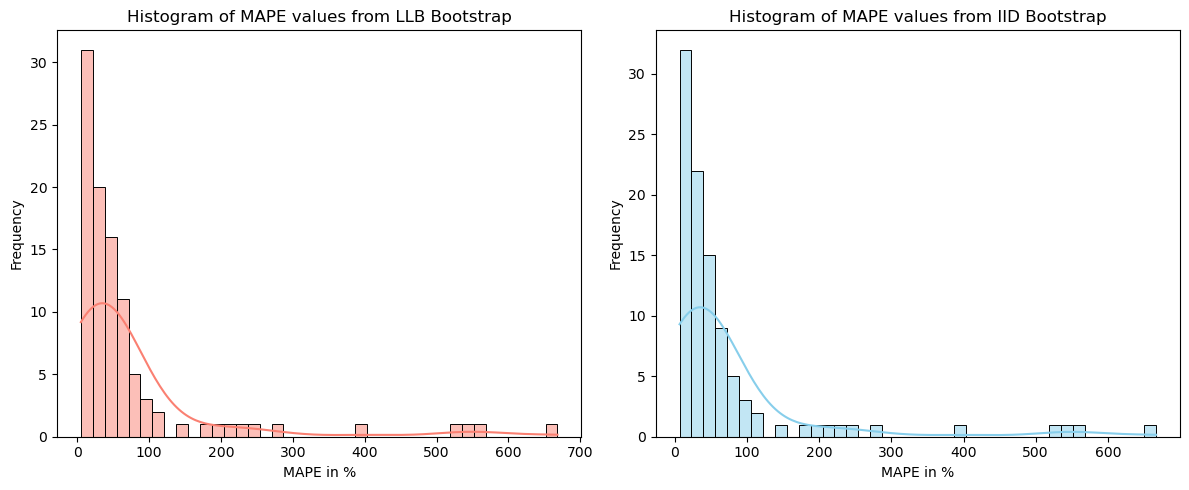

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_results.query("WINDOW_SIZE != 0")["MAPE"], bins=40, kde=True, color='salmon')
plt.xlabel("MAPE in %")
plt.ylabel("Frequency")
plt.title("Histogram of MAPE values from LLB Bootstrap")

plt.subplot(1, 2, 2)
sns.histplot(df_results.query("WINDOW_SIZE == 0")["MAPE"], bins=40, kde=True, color="skyblue")
plt.xlabel("MAPE in %")
plt.ylabel("Frequency")
plt.title("Histogram of MAPE values from IID Bootstrap")

plt.tight_layout()
plt.show()

# Error Analysis
- Model bias distribution -> Error distribution has high variance but is centered around 0
- Identifying and analysing outlier items -> 3 Error types: twins way to high, twins way to low, different seasonality curves

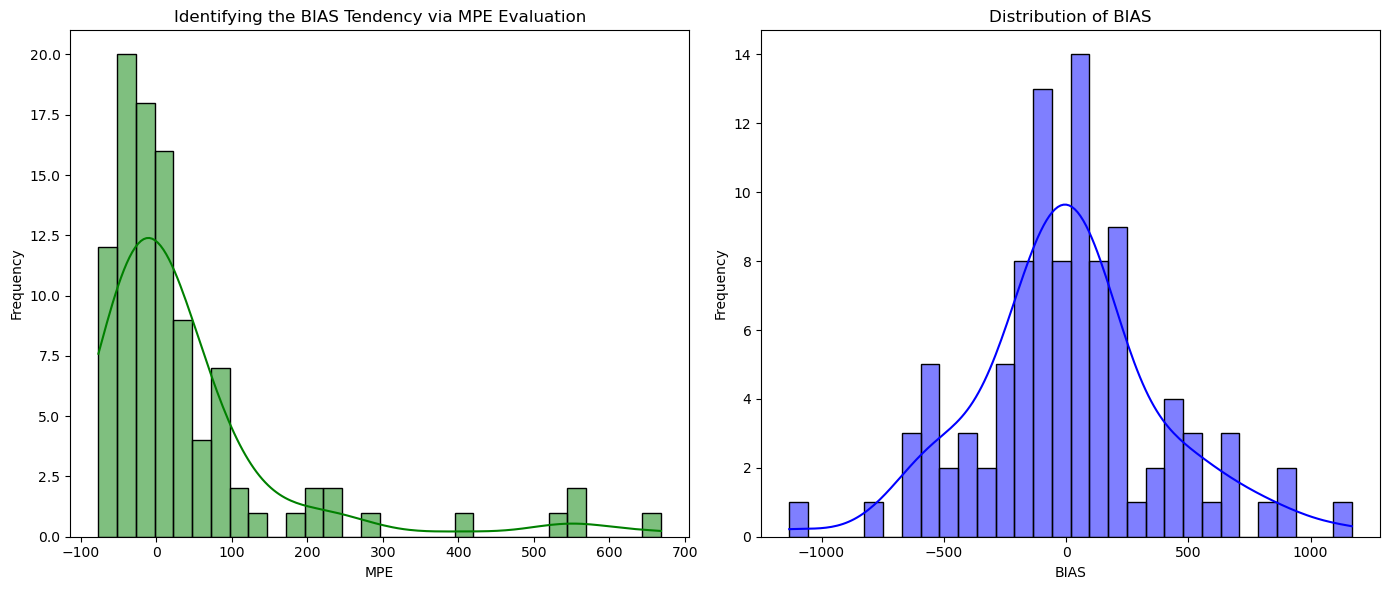

In [13]:
#note: mape is not symmetric!
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: LBB_MPE histogram
sns.histplot(df_results.query("WINDOW_SIZE != 0")["MPE"], bins=30, kde=True, color="green", ax=axes[0])
axes[0].set_xlabel("MPE")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Identifying the BIAS Tendency via MPE Evaluation")

# Second subplot: BIAS histogram
sns.histplot(df_results.query("WINDOW_SIZE != 0")["BIAS"], bins=30, kde=True, color="blue", ax=axes[1])
axes[1].set_xlabel("BIAS")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of BIAS")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
df_results.query("WINDOW_SIZE == 0").groupby("TEST_ITEM_COMMUNICATIONKEY").median().sort_values("MPE", ascending=True).reset_index()[["TEST_ITEM_COMMUNICATIONKEY", "MAPE", "MPE"]].head(10)
#863526628 twinws viel mehr Ansprache als test
#1107699346 twins viel mehr Ansprache als test
#848151556 twins viel mehr Ansprache als test
#1574713555 twins viel mehr Ansprache als test
#824008632 twins viel mehr Ansprache als test
#803656013 twins viel mehr Ansprache als test
#1088112515 twins viel mehr Ansprache als test
#829628090 twins viel mehr Ansprache als test
#... immer das gleiche

#848764870 hier passen die Saisonkurven nicht
#1066797131 hier passen die Saisonkurven nicht

#ansonsten sind logischerweise auch die twins mal geringer

,TEST_ITEM_COMMUNICATIONKEY,MAPE,MPE
0,1061289615,76.501500,-76.501500
1,842058910,70.390339,-70.390339
2,1064614421,68.136872,-68.136872
3,943969594,66.165332,-66.165332
4,848764870,65.649630,-65.649630
5,832962701,64.682050,-64.682050
6,1064646595,59.815265,-59.815265
7,837668025,57.720397,-57.720397
8,1066797131,57.587147,-57.587147
9,1063721481,54.807448,-54.807448


# Experiments

- Apply smoothing function on input time series, Idee: summer verändert sich nicht, risiko peaks zu samplen geht runter
-> ist vielleicht eine ganz glatte serie besser geeignet, um blöcke zu samplen -> dann ist der input weniger random
- Ansprache Marketing Imputed -> nahezu keine Auswirkung, dazu keine Verbesserung
- Influence of number of twins
- Change of observation period, change of product group
- Einfluss von NAs auf den Fehler
- Einfluss von Soldout auf den Fehler


# Normality test
- clt is defined for iid data
- distributions moments must be finite?
- tune number of iteration until distribution is normal -> helps simplify methods of robust optimization

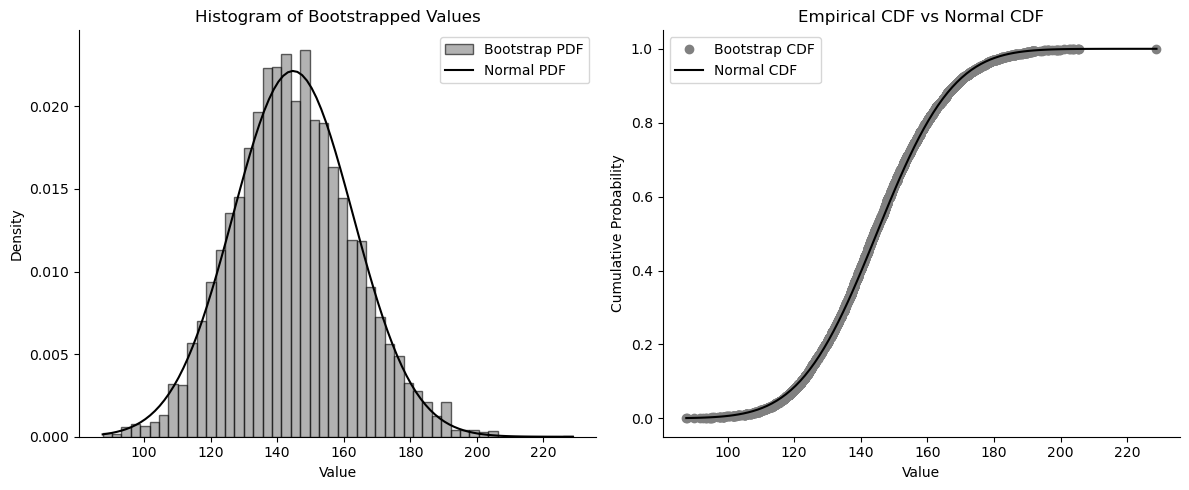

In [18]:
samples = Resampling.lb_bootstrap(input_data.TestData[804245827], 14, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(samples, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(samples), max(samples), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(samples)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [23]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05

In [ ]:
#generate integer samples from normal distribution
norm_samples = np.random.normal(50, 25, 100000).astype(int)

In [24]:
_, p_value = stats.normaltest(samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does NOT appear to be normally distributed.")

5.071147263410315e-08
Reject the null hypothesis: The data does NOT appear to be normally distributed.


In [25]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

5.705737762718961e-07
Reject the null hypothesis: The data does not appear to be normally distributed.
